# Brainstorming:

Problem: 
- User has large pdf file that has factory test data. 
- PDF file is too large: 22k pages
- Data is in a table format
- Data inside table is messy, need parsing/cleaning

General solution:
- Use python to parse pdf file
- Get data from pdf file, parse data in desire format, export into excel file for visualization later

Specific solution, pipeline:
- Use camelot to parse tables from pdf files
- Detect desire table, concat them.
- Cleaning and organizing data into a nice/correct df:
  - Check and drop extra column (Done)
  - Detect and concat tables
  - Seperate first cell into extra columns
- Export df into excel file

Design note:
- Hardcoded: check all tables, if tables 7 columns: drop first one: all tables should have 6



# Working code Maximum Output Power, on all files:


In [ ]:
import camelot
import pandas as pd
import numpy as np
from IPython.display import display
import time
import re
from PyPDF2 import PdfReader
import os 
import multiprocessing


def read_pdf(file_path):
    # Read the PDF file using Camelot
    print(f"Start reading PDF file {file_path}...")
    tables = camelot.read_pdf(file_path, pages='all' )
    # clean_tables(tables)
    return tables

def clean_table(table):
    # print(f"\nStart cleaning table...")
    # Check if the table has more than 1 column
    if table.shape[1] > 1:
        # print(f'Table has {table.shape[1]} columns. Cleaning up...')
        # # Drop the first column
        table = table.drop(columns=0)
        # Reset the column names
        table.columns = range(table.shape[1])
        # print(f'Table now has {table.shape[1]} columns.')
    return table

# Find target_table location in the PDF file: 
# return a list of page numbers
def find_table_location(pdf_file, target_table):
    print(f"Searching for table: {target_table}")
    
    reader = PdfReader(pdf_file)

    pages_with_table = []
    cont_table = False
    for page_num in range(len(reader.pages)):

        # Search each page's text for target table
        print(f"Searching page {page_num} out of {len(reader.pages)-1}")
        
        page = reader.pages[page_num]
        text = page.extract_text()
        
        # If target table is found, add the page number to the list, start a continuous table
        if target_table in text:
            print(f"Start new target table on page {page_num}")
            cont_table = True
            pages_with_table.append(page_num)
        #elif next page has 6.x.x.x pattern, end of continuous table, add the page number to the list
        elif re.search(r'\d+\.\d+\.\d+', text) and cont_table == True:
            print(f"End of continuous table on page {page_num}")
            cont_table = False
            pages_with_table.append(page_num)
        else:
            # print(f"Continuous table on page {page_num}")
            pass

    return pages_with_table

def convert_to_ranges(numbers):
    """
    Convert a list of numbers into a list of ranges.
    """
    ranges = []
    
    for i in range(0, len(numbers), 2):
        
        if i < len(numbers) - 1:
            ranges.append(f"{numbers[i]}-{numbers[i+1]}")
        else:
            ranges.append(str(numbers[i]))

    return ranges

def display_tables(tables):
    # Set the max column width to a high number (e.g., 1000) to display long contents
    pd.set_option('display.max_colwidth', 1000)

    # Display all tables
    print(f"Displaying {len(tables)} tables:")
    for i, table in enumerate(tables):
        table_number = i + 1
        print(f"\nTable {table_number}")
        display(table.df)

def display_processed_tables(tables):
    # Set the max column width to a high number (e.g., 1000) to display long contents
    pd.set_option('display.max_colwidth', 1000)

    # Display all processed tables
    print(f"\nDisplaying {len(tables)} tables:")
    for i, df in enumerate(tables):
        print(f"Table {i + 1}")
        display(df)

def extract_band(tables):
    print(f"Extracting Band info...")
    for table in tables:
        line2 = table.iloc[0,0]
        if 'Band' in line2:
            band_info = line2.split(' ')
            for word in band_info:
                if word.startswith('Band'):
                    band_num = word[4:]  # Extract everything after "Band"
                    table.insert(1, 'Band', band_num)
                    break
            else:
                print(f"No 'Band' keyword in line: {line2}")
    return tables

def extract_info(tables):
    print(f"Extracting Testname, ULCH, BW, MOD, RD info...")
    for i, table in enumerate(tables):
        # Define patterns
        testname_pattern = r"(.*):@"
        ulch_pattern = r"ULCH: (\d+),"
        bw_pattern = r"BW: ([\d\.]+ MHz)"
        mod_pattern = r"UL_MOD_RB: ([^,]+),"
        rd_pattern = r"UL_MOD_RB: [^,]+, (.*)"

        # Extract info
        table['Testname'] = table.iloc[:,0].str.extract(testname_pattern)
        table['ULCH'] = table.iloc[:,0].str.extract(ulch_pattern)
        table['BW'] = table.iloc[:,0].str.extract(bw_pattern)
        table['MOD'] = table.iloc[:,0].str.extract(mod_pattern)
        table['RD'] = table.iloc[:,0].str.extract(rd_pattern)

        # Drop the first column
        table.drop(table.columns[0], axis=1, inplace=True)

        # Reorganize the columns
        print(f"Reorganizing columns...")
        new_column_order = ['Testname', 'Band', 'ULCH', 'BW', 'MOD', 'RD', 'Limit Low', 'Limit High', 'Measured', 'Unit', 'Status']
        table = table.reindex(columns=new_column_order)

        # Replace the table in the list with the cleaned and reorganized table
        tables[i] = table
        
    return tables    

def find_target_table(tables, desired_name):
    
    current_table = None
    desired_tables = []
    
    #Run through table_list
    for table in tables:
        first_cell = table.df.iloc[0,0].split('\n')[0]

        #If the cell in first row, first column has the desire format "6.x.x.x" AND the desire_name: Start a new table
        if first_cell.startswith("6.") and desired_name in first_cell:
            # Found start of new desired table
            
            if current_table is None:
                current_table = table
            current_table = table.df.copy()
            # print(f"Found start of new desired table:")   
            # display(current_table)
        elif first_cell.startswith("6.") and desired_name not in first_cell: 
            #else: return the current table, and reset the current_table to None
            # print(f"\nSkipping a none-desired table: {first_cell}")
            if current_table is not None:
                # Save the current table
                desired_tables.append(current_table)
                #Reset, mark end of the desired table
                current_table = None
        
        #if the table doesnt match the desire_format AND there is a current_table: concat this table into the current table:         
        elif current_table is not None:
            # Continuation of previous desired table
            # print(f"Found continuation of previous desired table: {table.df.iloc[0,0]}")
            # print(f"Found continuous table, before cleaning:")   
            # display(table.df)
            #Clean table before concat:
            table.df = clean_table(table.df)
            # print(f"Continuous table after cleaning:")   
            # display(table.df)
            current_table = pd.concat([current_table, table.df])

            # print(f"Table after concat:")
            # display(current_table)
        
            
    return desired_tables

def process_tables(tables):  

    processed_tables = []
    
    for i, table in enumerate(tables):
        # print(f"\nProcessing table {i+1}...")
        # print(f"Table before processing:")
        # display(table)

    
        # Split the first cell of the first row and use it as column headers
        first_row = table.iloc[0, 0]
        headers = first_row.split('\n')  
        # print(f"First row: {first_row}")
        # print(f"Headers: {headers}")
        # headers.append("MissingHeader")
        table.columns = headers
        
        # Extract the table name from the first row
        table_name = table.iloc[0, 0].split('\n')[0]

        
        # Extract Band info from column 2
        # print(f"Extracting Band info...")
        line2 = table.iloc[1,0]
        # print(f"line2: {line2}")
        if 'Band' in line2:
            band_info = line2.split(' ')
            for word in band_info:
                if word.startswith('Band'):
                    band_num = word[4:]  # Extract everything after "Band"
                    table.insert(1, 'Band', band_num)
                    break
            else:
                print(f"No 'Band' keyword in line: {line2}")
         

        # print("Table after header:")
        # display(table)
          
        # # Check if the expected columns are in the table
        # if 'Unit' not in table.columns:
        #     print(f"Table {i+1} doesn't have the expected structure. Skipping...")
        #     continue
  
        # Extract Testname, ULCH, BW, MOD, RD info
        # print(f"Extracting Testname, ULCH, BW, MOD, RD info...")
        # Define patterns
        testname_pattern = r"(.*):@"
        ulch_pattern = r"ULCH: (\d+),"
        bw_pattern = r"BW: ([\d\.]+ MHz)"
        mod_pattern = r"UL_MOD_RB: ([^,]+),"
        rd_pattern = r"UL_MOD_RB: [^,]+, (.*)"

        # Extract info
        table['Testname'] = table.iloc[:,0].str.extract(testname_pattern)
        table['ULCH'] = table.iloc[:,0].str.extract(ulch_pattern)
        table['BW'] = table.iloc[:,0].str.extract(bw_pattern)
        table['MOD'] = table.iloc[:,0].str.extract(mod_pattern)
        table['RD'] = table.iloc[:,0].str.extract(rd_pattern)
        
        # print(f"Table before split Unit column:")
        # display(table)
   
        # Split 'Measured' and 'Unit' columns 
        # Create a temporary DataFrame for the split results
        split_df = table['Unit'].str.split(expand=True)

        # Assign the split results to 'Measured' and 'Unit' only where there are values
        table.loc[split_df[0].notna(), 'Measured'] = split_df.loc[split_df[0].notna(), 0]
        table.loc[split_df[1].notna(), 'Unit'] = split_df.loc[split_df[1].notna(), 1]

        # Drop the first column
        table.drop(table.columns[0], axis=1, inplace=True)

        # Create a new column filled with the table name
        table.insert(0, 'Table Name', table_name)
        table = table.iloc[1:]
        
        # Reorganize the columns
        # print(f"Reorganizing columns...")
        new_column_order = ['Table Name', 'Testname', 'Band', 'ULCH', 'BW', 'MOD', 'RD', 'Limit Low', 'Limit High', 'Measured', 'Unit', 'Status']
        table = table.reindex(columns=new_column_order)

        # Drop rows with NaN values in Testname and Band columns
        table = table.dropna(subset=['Testname'], how='all')


        # Reset the index
        table.reset_index(drop=True, inplace=True)
        
        #Append processed table to processed_tables:
        processed_tables.append(table)
        
        
    return processed_tables


#UI TKINTER:
import tkinter as tk
from tkinter import filedialog

# Add a GUI file picker
root = tk.Tk()
root.withdraw()
file_path = filedialog.askopenfilename()

pdf_file = file_path
# Extract name without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]

# "LTE_3GPP_v15_r8_FDD_FORD_All_TEMPS_TCU2_5_ROW_012023_5GSIM_AT_2023-06-28_16-27-57_188.pdf"
#  "25C_DATA_Extract(1temperatureOnly).pdf"
# "300_pages_extract.pdf"

target_table = "6.2.2 Maximum Output Power" 
# pdf_file = "300_pages_extract.pdf"
# Extract name without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]


# Find target table pages
pages = find_table_location(pdf_file, target_table)

# Format page numbers for camelot
page_ranges = convert_to_ranges(pages)
print(f"Pages to read: {page_ranges}")


clean_tables = []
total_ranges = len(page_ranges)


for i, page_range in enumerate(page_ranges):
    
    print(f"\nProcessing page range {i+1}/{total_ranges}...")
    # Calculate the estimate time remaining based on the progress so far
    progress = i / total_ranges
    time_remaining = (total_ranges - i) * 9 / 60
    print(f"Estimated time remaining: {time_remaining:.2f} minutes")
    
    start_time = time.time()
    # Read all tables from pdf
    long_tables = camelot.read_pdf(pdf_file, pages=page_range, backend="poppler")
    end_time = time.time()
    print(f"Time taken to load table: {end_time - start_time:.2f} seconds")
    
    start_time = time.time()
    desire_tables = find_target_table(long_tables, "6.2.2 Maximum Output Power")
    # display_processed_tables(desire_tables)
    end_time = time.time()
    print(f"Time taken to find target table: {end_time - start_time:.2f} seconds")
   
    
    start_time = time.time()
    processed_table = process_tables(desire_tables)
    end_time = time.time()
    print(f"Time taken to process tables: {end_time - start_time:.2f} seconds")
    display_processed_tables(processed_table)
    
    
    #append to clean_tables:
    clean_tables.extend(processed_table)


# Concatenate all the dataframes in the list into a single dataframe
all_tables = pd.concat(clean_tables, ignore_index=True)
display(all_tables.head(10)) # Display the first few rows of the resulting dataframe

# Save to Excel using file name
excel_file = f"final_{target_table}_{file_name}.xlsx" 
all_tables.to_excel(excel_file, index=False)

#Auto open folder:
import subprocess
import platform
folder_path = os.path.dirname(excel_file)

if platform.system() == 'Windows':
    os.startfile(folder_path)

elif platform.system() == 'Darwin': 
    subprocess.Popen(['open', folder_path])

else:
    subprocess.Popen(['xdg-open', folder_path])

# Working Extract 6.6.2.3 Adjacent Channel Leakage Power Ratio



In [ ]:
import camelot
import pandas as pd
import numpy as np
from IPython.display import display
import time
import re
from PyPDF2 import PdfReader
import os 
import tkinter as tk
from tkinter import filedialog
import subprocess
import platform

def read_pdf(file_path):
    # Read the PDF file using Camelot
    print(f"Start reading PDF file {file_path}...")
    tables = camelot.read_pdf(file_path, pages='all' )
    # clean_tables(tables)
    return tables

def pdf_to_text(pdf_file):
    reader = PdfReader(pdf_file)
    text = ''
    for page_num in range(len(reader.pages)):
        page = reader.pages[page_num]
        text += page.extract_text()
        print(f"Page num: {page_num+1}\nText: {text}")
    # Write the text to a file
    with open(f"{pdf_file}.txt", 'w') as file:
        file.write(text)

def clean_table(table):
    # print(f"\nStart cleaning table...")
    # Check if the table has more than 1 column
    if table.shape[1] > 1:
        # print(f'Table has {table.shape[1]} columns. Cleaning up...')
        # # Drop the first column
        table = table.drop(columns=0)
        # Reset the column names
        table.columns = range(table.shape[1])
        # print(f'Table now has {table.shape[1]} columns.')
    return table

def display_tables(tables):
    # Set the max column width to a high number (e.g., 1000) to display long contents
    pd.set_option('display.max_colwidth', 1000)

    # Display all tables
    print(f"Displaying {len(tables)} tables:")
    for i, table in enumerate(tables):
        table_number = i + 1
        print(f"\nTable {table_number}")
        display(table.df)

def display_processed_tables(tables):
    # Set the max column width to a high number (e.g., 1000) to display long contents
    pd.set_option('display.max_colwidth', 1000)

    # Display all processed tables
    print(f"\nDisplaying {len(tables)} tables:")
    for i, df in enumerate(tables):
        print(f"Table {i + 1}")
        display(df)

def find_table_location(pdf_file, target_table):
    print(f"Searching for table: {target_table}")
    
    reader = PdfReader(pdf_file)

    pages_with_table = []
    cont_table = False
    for page_num in range(len(reader.pages)):

        # Search each page's text for target table
        print(f"Searching page {page_num+1} out of {len(reader.pages)}")
        
        page = reader.pages[page_num]
        text = page.extract_text()
        
        # If target table is found, add the page number to the list, start a continuous table
        if target_table in text:
            target_index = text.index(target_table)
            # print(f'target index: {target_index}')
            # print(f"Content : {text[target_index:target_index+60]}")
            if "Limit Low" in text[target_index:target_index+56]:
                table_name = re.search(target_table, text).group(0)
                print(f"Start new target table '{text[target_index:target_index+56]}' on page {page_num+1}")
                cont_table = True
                pages_with_table.append(page_num+1)
            else:
                print(f"Found a false positive on page {page_num+1}")
        #elif next page has 6.x.x.x pattern, end of continuous table, add the page number to the list
        elif (re.search(r'\d+\.\d+\.\d+', text) or "Resource Block" in text) and cont_table == True:
            #Check if end of pdf file:
            if page_num == len(reader.pages)-1:
                print(f"End of continuous table on page {page_num}")
                cont_table = False
                pages_with_table.append(page_num)
            else:
                print(f"End of continuous table on page {page_num}")
                cont_table = False
                pages_with_table.append(page_num)
            
        else:
            # print(f"Continuous table on page {page_num}")
            pass

    return pages_with_table

def convert_to_ranges(numbers):
    """
    Convert a list of numbers into a list of ranges.
    """
    ranges = []
    
    for i in range(0, len(numbers), 2):
        
        if i < len(numbers) - 1:
            ranges.append(f"{numbers[i]}-{numbers[i+1]}")
        else:
            ranges.append(str(numbers[i]))

    return ranges

def find_target_table(tables, desired_name):
    
    current_table = None
    desired_tables = []
    rows_before_process = 0
    special_case = False
    #Run through table_list
    for table in tables:
        first_cell = table.df.iloc[0,0].split('\n')[0]
        # print(f"\nChecking table: {first_cell}")
        #If the cell in first row, first column has the desire format "6.x.x.x" AND the desire_name: Start a new table
        if first_cell.startswith("6.") and desired_name in first_cell:
            # Found start of new desired table
            # print(f"Found start of new desired table:{first_cell}") 
            
            if current_table is None:
                current_table = table.df.copy()
                rows_before_process = current_table.shape[0]-2
                
                # Check & handle special case:
                if current_table.shape[1] == 1:
                    print(f"Special case detected: {current_table.shape}")
                    # camelot.plot(table,kind='contour').show()
                    # camelot.plot(table,kind='joint').show()
                    
                    special_case = True
                #     # Handle the special case
                #     current_table = handle_special_case(current_table)
                    
            # print(f"Found start of new desired table:")   
            # display(current_table)

        
        #if the table doesnt match the desire_format AND there is a current_table: concat this table into the current table:         
        elif current_table is not None and not table.df.iloc[0][1].startswith("6.") and not table.df.iloc[0][0].startswith("6.") :  
            # Continuation of previous desired table
            # print(f"Found continuation of previous desired table: {table.df.iloc[0][1]}")
            # print(f"test: {table.df.iloc[0][1]}")
            # print(f"Found continuous table, before cleaning:")   
            # display(table.df)
            #Clean table before concat:
            table.df = clean_table(table.df)
            # print(f"Continuous table after cleaning:")   
            # display(table.df)
        
            #CONCAT TABLE:
            current_table = pd.concat([current_table, table.df])
            rows_before_process += table.df.shape[0]
            # print(f"Table after concat:")
            # display(current_table)
            if special_case:
                # Handle the special case
                current_table = handle_special_case(current_table)
                special_case = False  # Reset the flag
            # print(f"Table after fix special case:")
            # display(current_table)
            
            
            
        else: 
            #else: return the current table, and reset the current_table to None
            # print(f"Skipping a none-desired table: {first_cell}")
            if current_table is not None:
                # Save the current table
                # print(f"Saving table: {current_table}")
                desired_tables.append(current_table)
                
                #Reset, mark end of the desired table
                current_table = None
                
                       
    # Check if the last table in the list was a continuation of a desired table
    if current_table is not None:
        # print(f"Saving table: {current_table}")
        desired_tables.append(current_table)
        # print(f"Rows before processing: {rows_before_process}")
    return desired_tables, rows_before_process

def process_tables(tables):  

    processed_tables = []
    
    for i, table in enumerate(tables):
        # print(f"\nProcessing table {i+1}...")
        
        # Reset the index
        table = table.reset_index(drop=True)
        # print(f"Table before processing:")
        # display(table)
        
        # Fix rows that are split across pages
        print(f"Fixing rows that are split across pages...")
        for i in range(len(table)-1):
            # Check if the row should be joined with the preceding row
            # print(f"index {i}: {table.iloc[i, 0]}")
            if table.iloc[i, 0].startswith('UL_MOD_RB:') :
                # print(f"Found a row to join: index {i}: {table.iloc[i, 0]}")
                # Join the rows
                table.iloc[i-1, 0] += '\n' + table.iloc[i, 0]
                # # Drop the current row
                # table.drop(table.index[i], inplace=True)
        # print(f"Table after joining rows:{table}")
    
        # Split the first cell of the first row and use it as column headers
        first_row = table.iloc[0, 0]
        headers = first_row.split('\n')  
        # print(f"First row: {first_row}")
        # print(f"Headers: {headers}")
        # headers.append("MissingHeader")
        table.columns = headers
        
        # Extract the table name from the first row
        table_name = table.iloc[0, 0].split('\n')[0]

        
        # Extract Band info from column 2
        # print(f"Extracting Band info...")
        line2 = table.iloc[1,0]
        # print(f"line2: {line2}")
        if 'Band' in line2:
            band_info = line2.split(' ')
            for word in band_info:
                if word.startswith('Band'):
                    band_num = word[4:]  # Extract everything after "Band"
                    table.insert(1, 'Band', band_num)
                    break
            else:
                print(f"No 'Band' keyword in line: {line2}")
         

        # print("Table after header:")
        # display(table)
 
  
        # Extract Testname, ULCH, BW, MOD, RD info
        # print(f"Extracting Testname, ULCH, BW, MOD, RD info...")
        # Define patterns
        testname_pattern = r"(.*):@"
        ulch_pattern = r"ULCH: (\d+),"
        bw_pattern = r"BW: ([\d\.]+ MHz)"
        mod_pattern = r"UL_MOD_RB: ([^,]+),"
        rd_pattern = r"UL_MOD_RB: [^,]+, (.*)"

        # Extract info
        table['Testname'] = table.iloc[:,0].str.extract(testname_pattern)
        table['ULCH'] = table.iloc[:,0].str.extract(ulch_pattern)
        table['BW'] = table.iloc[:,0].str.extract(bw_pattern)
        table['MOD'] = table.iloc[:,0].str.extract(mod_pattern)
        table['RD'] = table.iloc[:,0].str.extract(rd_pattern)
        
        # print(f"Table before split Unit column:")
        # display(table)
   
        # Split 'Measured' and 'Unit' columns 
        # Create a temporary DataFrame for the split results
        split_df = table['Unit'].str.split(expand=True)

        # Assign the split results to 'Measured' and 'Unit' only where there are values
        table.loc[split_df[0].notna(), 'Measured'] = split_df.loc[split_df[0].notna(), 0]
        table.loc[split_df[1].notna(), 'Unit'] = split_df.loc[split_df[1].notna(), 1]

        # Drop the first column
        table.drop(table.columns[0], axis=1, inplace=True)

        # Create a new column filled with the table name
        table.insert(0, 'Table Name', table_name)
        table = table.iloc[1:]
        
        # Reorganize the columns
        # print(f"Reorganizing columns...")
        new_column_order = ['Table Name', 'Testname', 'Band', 'ULCH', 'BW', 'MOD', 'RD', 'Limit Low', 'Limit High', 'Measured', 'Unit', 'Status']
        table = table.reindex(columns=new_column_order)

        # print(f"Table before drop columns:")
        # display(table)
        # Drop rows with NaN values in Testname
        table = table.dropna(subset=['Testname'], how='all')


        # Reset the index
        table.reset_index(drop=True, inplace=True)
        print(f"Table after processing:{table}")

        #Append processed table to processed_tables:
        processed_tables.append(table)
        
        
        
    return processed_tables

def handle_special_case(current_table):
    """
    Handle special case where table at end of pdf: camelot parse weird format: missing info
    Table only has one column.
    Split the information in the cell into different columns.
    """
    # Loop through all the rows in the current table
    for row_index in range(current_table.shape[0]):

        # Check if the row contains "dB" or "Passed"
        if "dB" in current_table.iloc[row_index, 0] or "Passed" in current_table.iloc[row_index, 0]:

            # Split the row into different parts
            row_parts = current_table.iloc[row_index, 0].split('\n')

            # Assign each part to its corresponding column
            current_table.iloc[row_index, 1] = row_parts[1]
            current_table.iloc[row_index, 4] = row_parts[3]
            current_table.iloc[row_index, 5] = row_parts[4]
            current_table.iloc[row_index, 2] = '---'
            # Remove the parts that have been moved from the row_parts list
            del row_parts[1:5]

            # Join the remaining parts and update the original cell
            current_table.iloc[row_index, 0] = '\n'.join(row_parts)

    return current_table

def select_file():
    # Add a GUI file picker
    root = tk.Tk()
    root.withdraw()
    file_path = filedialog.askopenfilename()
    return file_path

def concatenate_tables(clean_tables, target_table, pdf_file):
    # Concatenate all the dataframes in the list into a single dataframe
    # Extract name without extension
    file_name = os.path.splitext(os.path.basename(pdf_file))[0]

    if not clean_tables:
        print("No tables extracted")
        return pd.DataFrame()
    else:
        all_tables = pd.concat(clean_tables, ignore_index=True)
        display(all_tables.head(10)) # Display the first few rows of the resulting dataframe
        #Extract table name:
        table_name = target_table.split()[1] 
        # Save to Excel using file name
        excel_file = f"{table_name}_{file_name}.xlsx"
        all_tables.to_excel(excel_file, index=False)

        # Auto open folder:
        folder_path = os.path.abspath(os.path.dirname(excel_file))
        if platform.system() == 'Windows':
            os.startfile(folder_path)
        elif platform.system() == 'Darwin': 
            subprocess.Popen(['open', folder_path])
        else:
            subprocess.Popen(['xdg-open', folder_path])

        return all_tables

    

#Run through all pages, get table, concatentate, clean --> clean dataframes:
import logging
logging.basicConfig(level=logging.INFO)

def run(pdf_file, target_table):
    
    ranges_text_file = f"{pdf_file}_{target_table}.txt"
    
    # Check if page range text file exists:
    if os.path.exists(ranges_text_file):
        print(f"Check and load page ranges from text file: {ranges_text_file}")
        # Load page ranges from text file:
        with open(ranges_text_file, "r") as file:
            page_ranges = eval(file.read())
    else:
        # Find target table pages location:
        pages = find_table_location(pdf_file, target_table)

        # Format page numbers for camelot
        page_ranges = convert_to_ranges(pages)
        
        # Save page ranges to text file:
        with open(ranges_text_file, "w") as file:
            file.write(str(page_ranges))
        print(f"Saved page ranges to text file: {ranges_text_file}")
        
    print(page_ranges)
    print(f"Found {len(page_ranges)} tables")
    
    # Run through all pages, get table, concatenate, clean --> clean dataframes:
    clean_tables = []
    total_ranges = len(page_ranges)
    
    tol_rows_before_processing = 0 
    for i, page_range in enumerate(page_ranges):
        print(f"\nProcessing {i+1}/{total_ranges}: {page_range}")
        logging.info(f'Processing page range {page_range}')
        
        
        # Read all tables from pdf
        start_time = time.time()
        long_tables = camelot.read_pdf(pdf_file, pages=page_range, backend="poppler")
        end_time = time.time()
        time_load_table = end_time - start_time
        print(f"Time taken to load table: {end_time - start_time:.2f} seconds")

        
        #Find and concatenate target tables:
        desire_tables, rows_before_processing = find_target_table(long_tables, target_table)
        tol_rows_before_processing += rows_before_processing
        # display_processed_tables(desire_tables)
        # end_time = time.time()
       
       #Process/clean tables:
        start_time = time.time()
        processed_table = process_tables(desire_tables)
        end_time = time.time()
        # print(f"Time taken to process tables: {end_time - start_time:.2f} seconds")
        # print(f"Page range {page_range} has {len(processed_table)} tables")
        display_processed_tables(processed_table)

        # Append to clean_tables:
        clean_tables.extend(processed_table)
        
        # Calculate the estimate time remaining based on the progress so far
        progress = i / total_ranges
        time_remaining = (total_ranges - i) * time_load_table / 60
        print(f"Estimated time remaining: {time_remaining:.2f} minutes")
        logging.info(f'Time taken: {time.time() - start_time}')

    # Concatenate all the dataframes in the list into a single dataframe
    final_df = concatenate_tables(clean_tables, target_table, pdf_file)
    # get the number of rows in the DataFrame
    print(f"Number of rows before processing: {tol_rows_before_processing}")
    print(f"Final table has {final_df.shape[0]} rows")
  
  

#Set up target table:
 # pdf_file = select_file()   
 
#options
maximum_table = "6.2.2 Maximum Output Power" 
adjacent_table = "6.6.2.3 Adjacent Channel Leakage Power Ratio" 
long_file = "22k.pdf"
med_file = "/Users/huyknguyen/Desktop/paul-processing-tool/pdf/4436pages.pdf"
shortFile = "/Users/huyknguyen/Desktop/paul-processing-tool/pdf/6.6.2.3 500 pages.pdf"

pdf_file = med_file
target_table = adjacent_table
run(pdf_file, target_table)




# Turn into Class (Working)

In [ ]:
import camelot
import pandas as pd
import numpy as np
from IPython.display import display
import time
import re
from PyPDF2 import PdfReader
import os 
import tkinter as tk
from tkinter import filedialog
import subprocess
import platform
import logging
logging.basicConfig(level=logging.INFO)

class PDFTableExtractor:

    def __init__(self, pdf_file, target_table):
        self.pdf_file = pdf_file
        self.target_table = target_table
        
        
    @staticmethod
    def select_file(self):
        # Add a GUI file picker
        root = tk.Tk()
        root.withdraw()
        file_path = filedialog.askopenfilename()
        return file_path

    def find_table_location(self):
        print(f"Searching for table: {self.target_table}")

        reader = PdfReader(self.pdf_file)

        pages_with_table = []
        cont_table = False
        for page_num in range(len(reader.pages)):
            #print out page number after 1000 pages:
            if page_num % 1000 == 0:
                print(f"Searching page {page_num+1} out of {len(reader.pages)}")
            
            page = reader.pages[page_num]
            text = page.extract_text()
            
            if self.target_table in text:
                target_index = text.index(self.target_table)
                if "Limit Low" in text[target_index:target_index+56]:
                    print(f"Start new target table on page {page_num+1}")
                    cont_table = True
                    pages_with_table.append(page_num+1)
                else:
                    print(f"Found a false positive on page {page_num+1}")
            elif (re.search(r'\d+\.\d+\.\d+', text) or "Resource Block" in text) and cont_table:
                if page_num == len(reader.pages)-1:
                    print(f"End of table on page {page_num}")
                    cont_table = False
                    pages_with_table.append(page_num)
                else:
                    print(f"End of table on page {page_num}")
                    cont_table = False
                    pages_with_table.append(page_num)            
            else:
                pass
                
        return pages_with_table
    
    def clean_table(self, table):
        # print(f"\nStart cleaning table...")
        # Check if the table has more than 1 column
        if table.shape[1] > 1:
            # print(f'Table has {table.shape[1]} columns. Cleaning up...')
            # # Drop the first column
            table = table.drop(columns=0)
            # Reset the column names
            table.columns = range(table.shape[1])
            # print(f'Table now has {table.shape[1]} columns.')
        return table

    def get_page_ranges(self):
        # Create filename to cache page ranges
        ranges_text_file = f"{self.pdf_file}_{self.target_table}.txt"  

        if os.path.exists(ranges_text_file):

            print(f"Loading page ranges from {ranges_text_file}")
            
            with open(ranges_text_file, "r") as f:
                page_ranges = eval(f.read())

        else:

            print(f"Finding page ranges for {self.target_table}")
            
            pages = self.find_table_location()
            page_ranges = self.convert_to_ranges(pages)
            
            print(f"Saving page ranges to {ranges_text_file}")
            
            with open(ranges_text_file, "w") as f:  
                f.write(str(page_ranges))

        return page_ranges
    
    def estimate_total_time(self, page_ranges, load_times, process_times):

        num_ranges = len(page_ranges)
        
        avg_load_time = sum(load_times) / len(load_times)
        avg_process_time = sum(process_times) / len(process_times)
        
        est_total = num_ranges * (avg_load_time + avg_process_time)
        
        print(f"Average load time: {avg_load_time:.2f} secs")
        print(f"Average process time: {avg_process_time:.2f} secs")
        print(f"Estimated total time: {est_total/60:.2f} mins")
    
    def convert_to_ranges(self, numbers):
        ranges = []
        for i in range(0, len(numbers), 2):
            if i < len(numbers) - 1:
                ranges.append(f"{numbers[i]}-{numbers[i+1]}")
            else:
                ranges.append(str(numbers[i]))

        return ranges
    
    def find_target_table(self, tables):
        current_table = None
        desired_tables = []
        rows_before_process = 0
        special_case = False
        
        for table in tables:
            first_cell = table.df.iloc[0,0].split('\n')[0]
            
            if first_cell.startswith("6.") and self.target_table in first_cell:
                if current_table is None:
                    current_table = table.df.copy()
                    rows_before_process = current_table.shape[0]-2
                    
                    if current_table.shape[1] == 1:
                        special_case = True
                        
            elif current_table is not None and not table.df.iloc[0][1].startswith("6.") and not table.df.iloc[0][0].startswith("6."):
                table.df = self.clean_table(table.df)
        
                current_table = pd.concat([current_table, table.df])
                rows_before_process += table.df.shape[0]
                if special_case:
                    current_table = self.handle_special_case(current_table)
                    special_case = False
                    
            else:
                if current_table is not None:
                    desired_tables.append(current_table)
                    current_table = None
            
        if current_table is not None:
            desired_tables.append(current_table)
            
        return desired_tables, rows_before_process

    def process_tables(self, tables):
        processed_tables = []
        
        for table in tables:
            table = table.reset_index(drop=True)
            
            for i in range(len(table)-1):
                if table.iloc[i, 0].startswith('UL_MOD_RB:'):
                    table.iloc[i-1, 0] += '\n' + table.iloc[i, 0]

            first_row = table.iloc[0, 0]
            headers = first_row.split('\n')
            table.columns = headers
            
            table_name = table.iloc[0, 0].split('\n')[0]
            
            line2 = table.iloc[1,0]
            if 'Band' in line2:
                band_info = line2.split(' ')
                for word in band_info:
                    if word.startswith('Band'):
                        band_num = word[4:]  
                        table.insert(1, 'Band', band_num)
                        break
            
            # Extraxt Testname, ULCH, etc
            testname_pattern = r"(.*):@"
            
            table['Testname'] = table.iloc[:,0].str.extract(testname_pattern)
            table['ULCH'] = table.iloc[:,0].str.extract(r"ULCH: (\d+),")
            table['BW'] = table.iloc[:,0].str.extract(r"BW: ([\d\.]+ MHz)")
            table['MOD'] = table.iloc[:,0].str.extract(r"UL_MOD_RB: ([^,]+),")
            table['RD'] = table.iloc[:,0].str.extract(r"UL_MOD_RB: [^,]+, (.*)")
            
            # Split Unit column
            split_df = table['Unit'].str.split(expand=True)
            table.loc[split_df[0].notna(), 'Measured'] = split_df.loc[split_df[0].notna(), 0]
            table.loc[split_df[1].notna(), 'Unit'] = split_df.loc[split_df[1].notna(), 1]
            table.drop(table.columns[0], axis=1, inplace=True)
            
            table.insert(0, 'Table Name', table_name)
            table = table.iloc[1:]
            
            new_column_order = ['Table Name', 'Testname', 'Band', 'ULCH', 'BW', 'MOD', 'RD', 'Limit Low', 'Limit High', 'Measured', 'Unit', 'Status']
            table = table.reindex(columns=new_column_order)
            table = table.dropna(subset=['Testname'], how='all')
            table.reset_index(drop=True, inplace=True)

            processed_tables.append(table)

        return processed_tables

    def handle_special_case(self, table):
        for row_index in range(table.shape[0]):
            if "dB" in table.iloc[row_index, 0] or "Passed" in table.iloc[row_index, 0]:
                row_parts = table.iloc[row_index, 0].split('\n')
                table.iloc[row_index, 1] = row_parts[1] 
                table.iloc[row_index, 4] = row_parts[3]
                table.iloc[row_index, 5] = row_parts[4]
                table.iloc[row_index, 2] = '---'
                del row_parts[1:5]
                table.iloc[row_index, 0] = '\n'.join(row_parts)

        return table

    def concatenate_tables(self, tables):
        #Extract file name without extension
        file_name = os.path.splitext(os.path.basename(self.pdf_file))[0]


        
        if not tables:
            print("No tables extracted")
            return pd.DataFrame()
        else:
            all_tables = pd.concat(tables, ignore_index=True)
            table_name = self.target_table.split()[1]
            
              # Add 2 new column
            # Extract temperature 
            filename = os.path.basename(self.pdf_file) 
            temp = re.search(r'_TEMPHERE(\S+)\.', filename).group(1)
            all_tables['Temperature'] = temp
              # Extract PDF filename 
            pdf_name = os.path.basename(self.pdf_file)
            all_tables['PDF Name'] = pdf_name
            
            excel_file = f"{table_name}_{file_name}.xlsx"
            all_tables.to_excel(excel_file, index=False)

            folder_path = os.path.abspath(os.path.dirname(excel_file))
            if platform.system() == 'Windows':
                os.startfile(folder_path)
            elif platform.system() == 'Darwin':
                subprocess.Popen(['open', folder_path])
            else:
                subprocess.Popen(['xdg-open', folder_path])

            return all_tables


    def run(self):
        load_times = []
        process_times = []
    
        # Get page ranges, loading from cache if exists
        page_ranges = self.get_page_ranges()
        
        # Print out number of tables found
        print(f"Found {len(page_ranges)} tables")
        # Print page ranges for debugging
        print(f"Page ranges: {page_ranges}")

        # Extract tables page-by-page
        clean_tables = []
        for i, page_range in enumerate(page_ranges):

            # Load PDF tables for this page range
            start = time.time()
            tables = camelot.read_pdf(self.pdf_file, pages=page_range)
            #print out time to load table:
            end = time.time()
            load_times.append(time.time() - start)

            # Find target tables and get rows count
            desired_tables, rows = self.find_target_table(tables)

            # Process target tables
            start = time.time()
            processed_tables = self.process_tables(desired_tables)
            process_times.append(time.time() - start)
            # if i >= 5: 
            self.estimate_total_time(page_ranges, load_times, process_times)

            # Add to list of clean tables
            clean_tables.extend(processed_tables)

        # Concatenate all clean tables into final DataFrame
        final_df = self.concatenate_tables(clean_tables)
    
        return final_df
    

 
#options
maximum_table = "6.2.2 Maximum Output Power" 
adjacent_table = "6.6.2.3 Adjacent Channel Leakage Power Ratio" 
long_file = "22k.pdf"
med_file = "/Users/huyknguyen/Desktop/paul-processing-tool/pdf/4436pages.pdf"
shortFile = "/Users/huyknguyen/Desktop/paul-processing-tool/pdf/6.6.2.3 500 pages_TEMPHERE-10C.pdf"
new75c = "/Users/huyknguyen/Desktop/paul-processing-tool/pdf/LTE_3GPP_v15_r8_FDD_FORD_All_TEMPS_TCU2_5_ROW_012023_5GSIM_AT_2023-06-28_16-27-57_188_TEMP75C.pdf"
new25c = "/Users/huyknguyen/Desktop/paul-processing-tool/pdf/LTE_3GPP_v15_r8_FDD_FORD_All_TEMPS_TCU2_5_ROW_012023_5GSIM_AT_2023-06-28_16-27-57_188_TEMP25C.pdf"
pdf_file = shortFile
target_table = adjacent_table

#User select multiple files:
root = tk.Tk()
root.withdraw()
filepaths = filedialog.askopenfilenames()


# Usage:
if len(filepaths) == 1:
    # Single file selected
    extractor = PDFTableExtractor(filepaths[0], target_table)
    final_df = extractor.run()

else:
    # Multiple files selected
    all_tables = []
    for filepath in filepaths:
        extractor = PDFTableExtractor(filepath, target_table)
        df = extractor.run()  # Changed variable name to `df`
        all_tables.append(df)  # Appending `df` instead of `tables`
    
    # Concatenate results:
    final_df = pd.concat(all_tables, ignore_index=True)

# Save to Excel
excel_file = "Final_Table.xlsx"
final_df.to_excel(excel_file, index=False)  # Save `final_df` instead of `all_tables`

# Open file
if platform.system() == 'Windows':
    os.startfile(excel_file)
elif platform.system() == 'Darwin':
    subprocess.Popen(['open', excel_file])
else:
    subprocess.Popen(['xdg-open', excel_file])


# Visualization

Unique bands: [ 1  2  3  4  5  7  8 20 28 38 40 41]


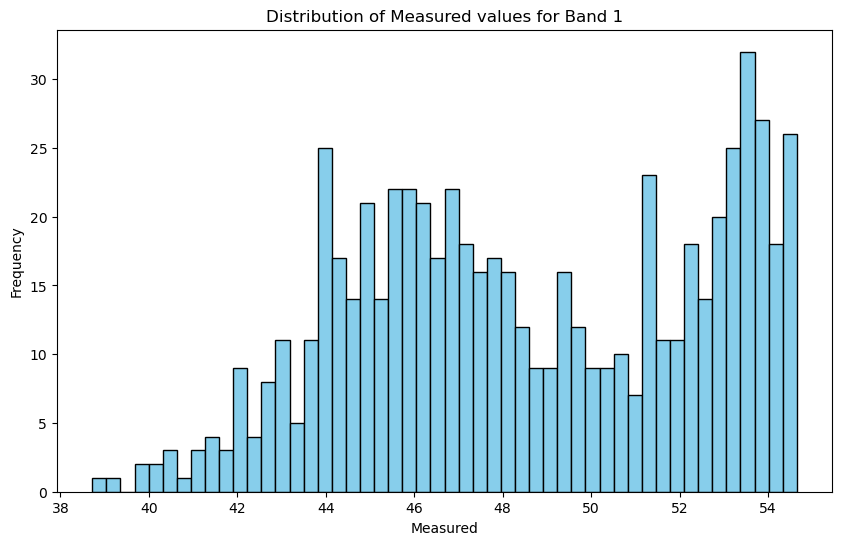

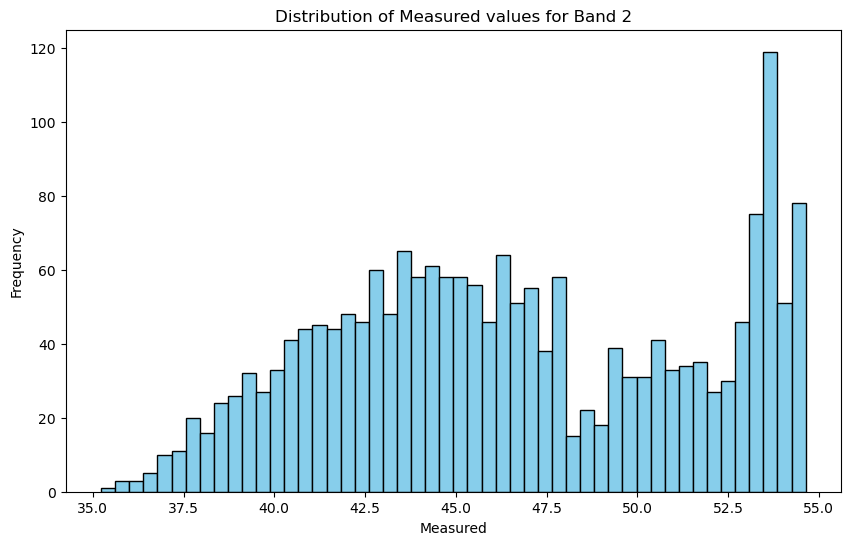

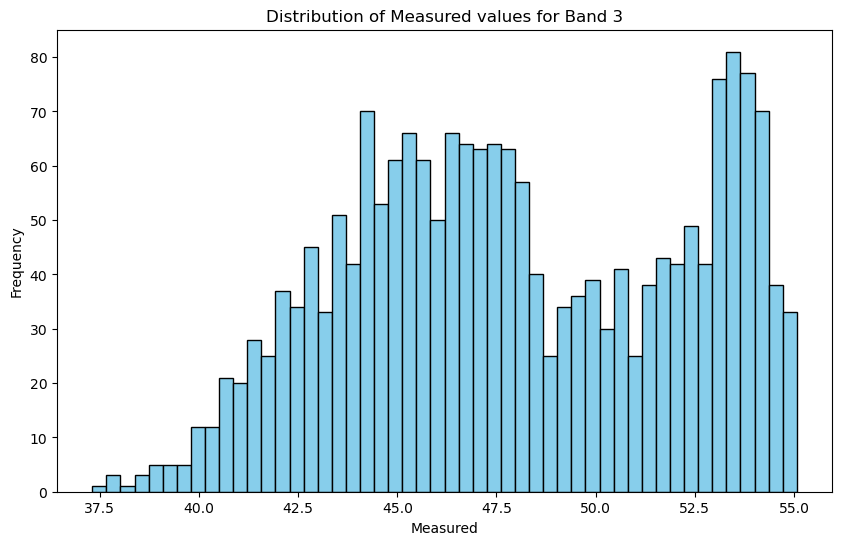

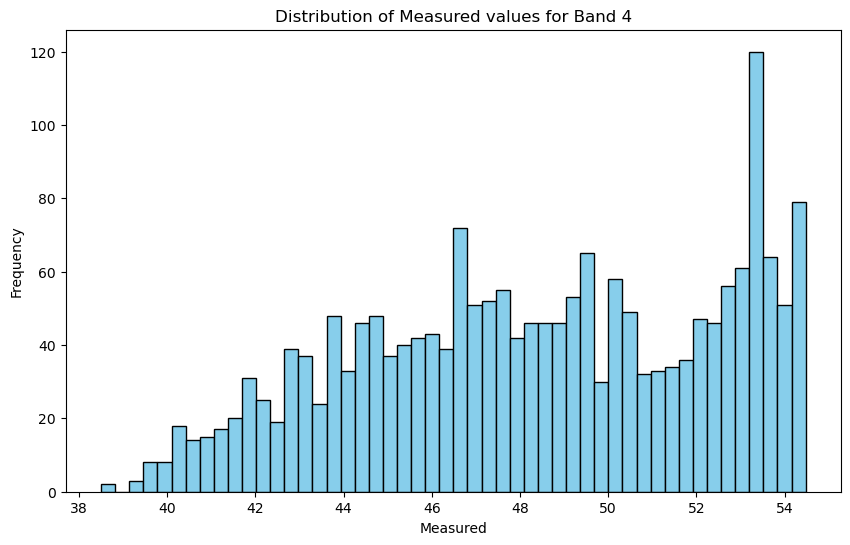

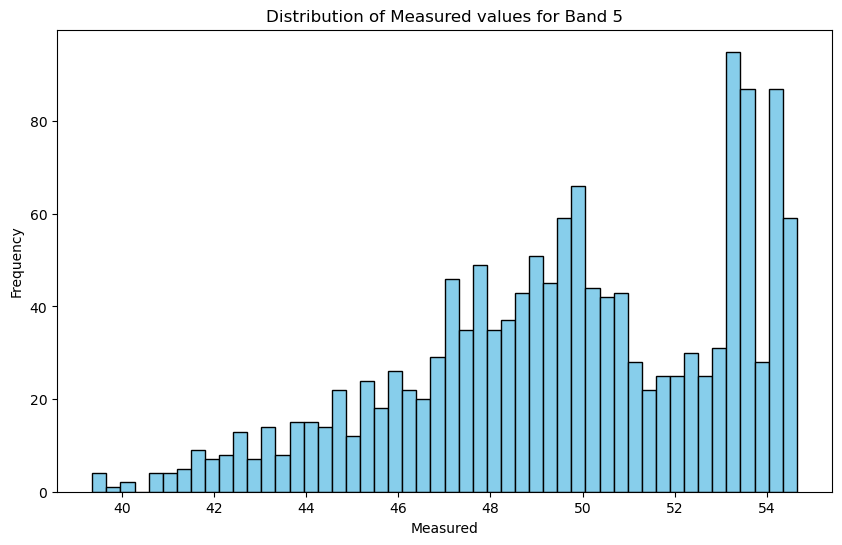

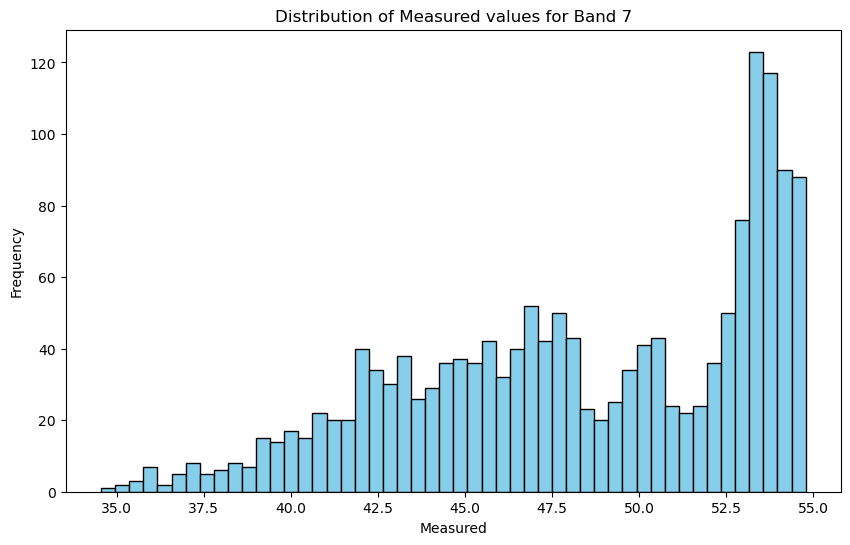

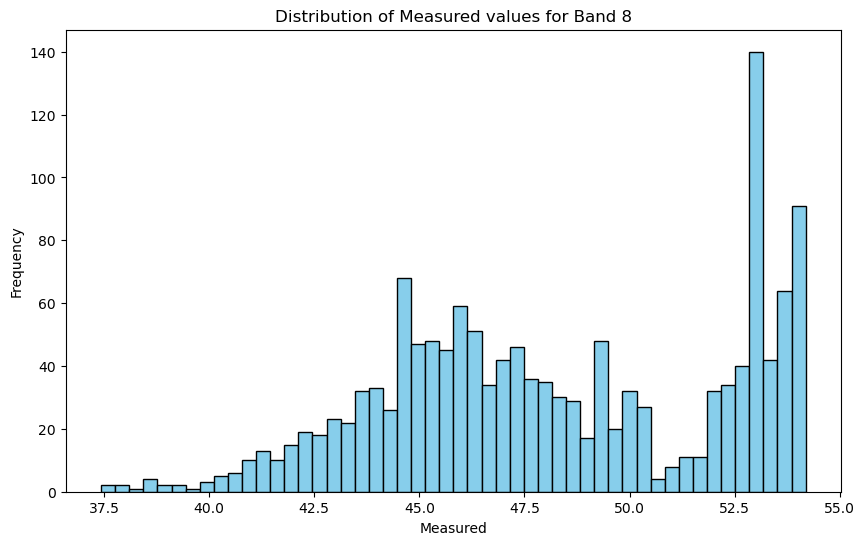

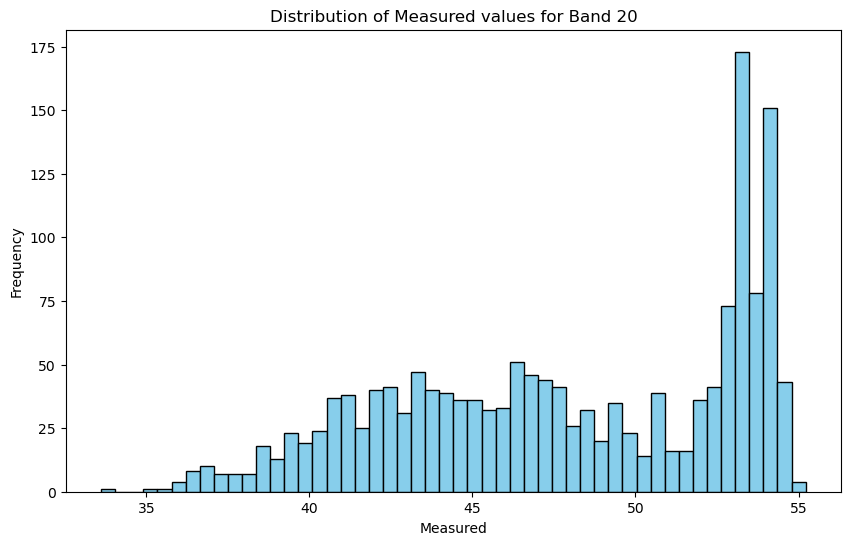

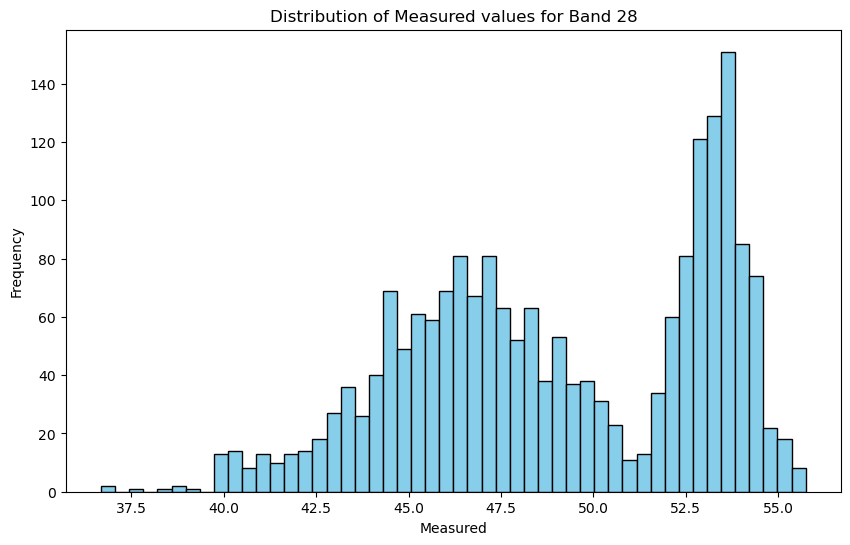

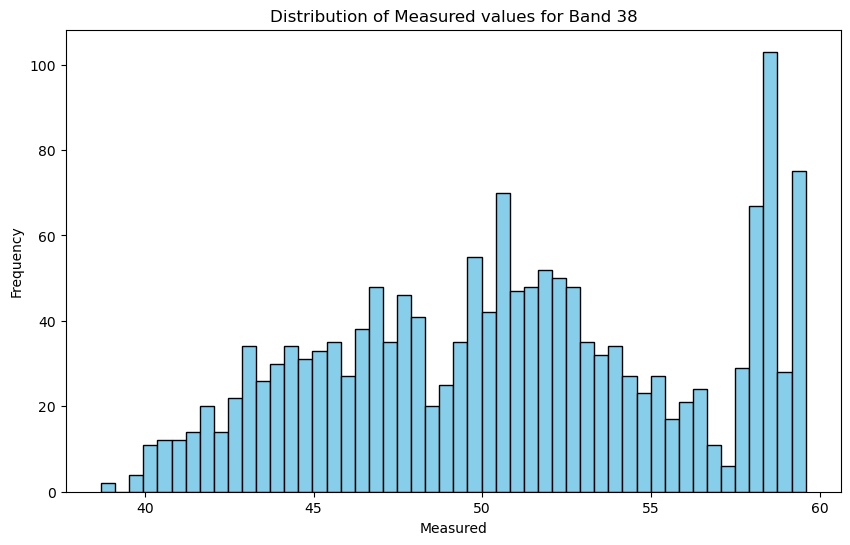

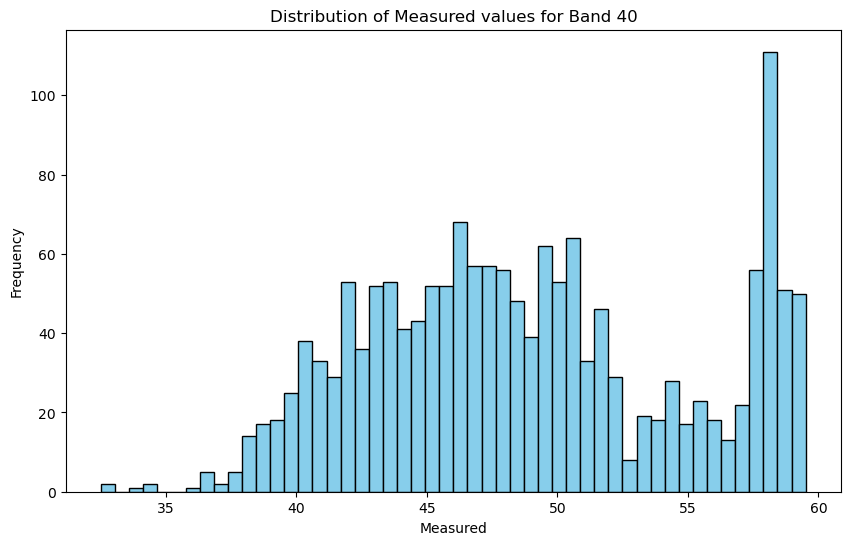

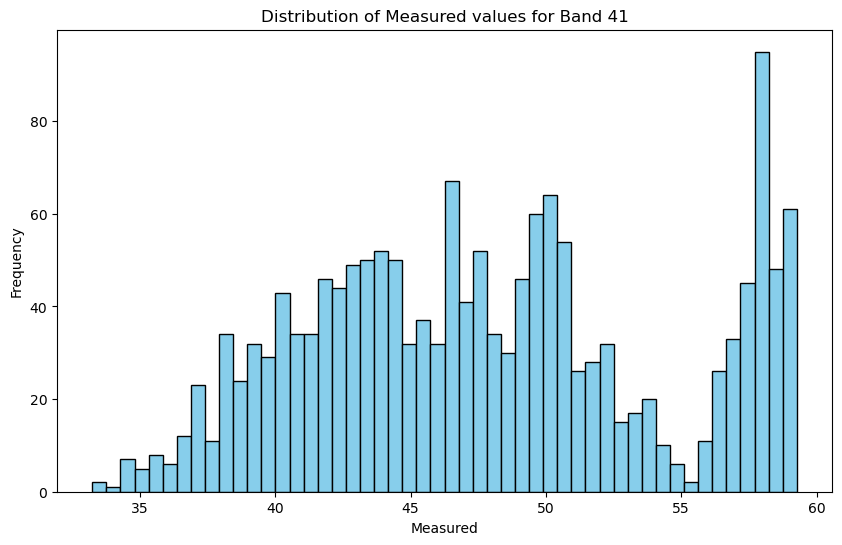

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# # Load excel file to dataframe
# df = pd.read_excel("Adjacent_22k.xlsx")

# Convert the "Measured" column to numeric
df['Measured'] = pd.to_numeric(df['Measured'], errors='coerce')

# Get unique bands
unique_bands = df['Band'].unique()
print(f"Unique bands: {unique_bands}")

# For each unique band, create a separate histogram
for band in unique_bands:
    plt.figure(figsize=(10, 6))
    plt.hist(df[df['Band'] == band]['Measured'].dropna(), bins=50, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of Measured values for Band {band}')
    plt.xlabel('Measured')
    plt.ylabel('Frequency')
    plt.show()



# Test on 1 table
# Fixed Adjacent missing data (process_table function)




In [ ]:
def find_target_table(tables, desired_name):
    
    current_table = None
    desired_tables = []
    rows_before_process = 0
    special_case = False
    #Run through table_list
    for table in tables:
        first_cell = table.df.iloc[0,0].split('\n')[0]
        # print(f"\nChecking table: {first_cell}")
        #If the cell in first row, first column has the desire format "6.x.x.x" AND the desire_name: Start a new table
        if first_cell.startswith("6.") and desired_name in first_cell:
            # Found start of new desired table
            # print(f"Found start of new desired table:{first_cell}") 
            
            if current_table is None:
                current_table = table.df.copy()
                rows_before_process = current_table.shape[0]-2
                # camelot.plot(table,kind='contour').show()
                camelot.plot(table,kind='joint').show()
                # Check & handle special case:
                if current_table.shape[1] == 1:
                    print(f"Special case detected: {current_table.shape}")

                    
                    special_case = True
                #     # Handle the special case
                #     current_table = handle_special_case(current_table)
                    
            print(f"Found start of new desired table:")   
            display(current_table)

        
        #if the table doesnt match the desire_format AND there is a current_table: concat this table into the current table:         
        elif current_table is not None and not table.df.iloc[0][1].startswith("6.") and not table.df.iloc[0][0].startswith("6.") :  
            # Continuation of previous desired table
            # print(f"Found continuation of previous desired table: {table.df.iloc[0][1]}")
            # print(f"test: {table.df.iloc[0][1]}")
            print(f"Found continuous table, before cleaning:")   
            display(table.df)
            #Clean table before concat:
            table.df = clean_table(table.df)
            # print(f"Continuous table after cleaning:")   
            # display(table.df)
        
            #CONCAT TABLE:
            current_table = pd.concat([current_table, table.df])
            rows_before_process += table.df.shape[0]
            print(f"Table after concat:")
            display(current_table)
            if special_case:
                # Handle the special case
                current_table = handle_special_case(current_table)
                special_case = False  # Reset the flag
            print(f"Table after fix special case:")
            display(current_table)
            
            
            
        else: 
            #else: return the current table, and reset the current_table to None
            # print(f"Skipping a none-desired table: {first_cell}")
            if current_table is not None:
                # Save the current table
                # print(f"Saving table: {current_table}")
                desired_tables.append(current_table)
                
                #Reset, mark end of the desired table
                current_table = None
                
                       
    # Check if the last table in the list was a continuation of a desired table
    if current_table is not None:
        # print(f"Saving table: {current_table}")
        desired_tables.append(current_table)
        # print(f"Rows before processing: {rows_before_process}")
    return desired_tables, rows_before_process

def process_tables(tables):  

    processed_tables = []
    
    for i, table in enumerate(tables):
        # print(f"\nProcessing table {i+1}...")
        
        # Reset the index
        table = table.reset_index(drop=True)
        # print(f"Table before processing:")
        # display(table)
        
        # Fix rows that are split across pages
        print(f"Fixing rows that are split across pages...")
        for i in range(len(table)-1):
            # Check if the row should be joined with the preceding row
            # print(f"index {i}: {table.iloc[i, 0]}")
            if table.iloc[i, 0].startswith('UL_MOD_RB:') :
                print(f"Found a row to join: index {i}: {table.iloc[i, 0]}")
                # Join the rows
                table.iloc[i-1, 0] += '\n' + table.iloc[i, 0]
                # # Drop the current row
                # table.drop(table.index[i], inplace=True)
        # print(f"Table after joining rows:{table}")
    
        # Split the first cell of the first row and use it as column headers
        first_row = table.iloc[0, 0]
        headers = first_row.split('\n')  
        # print(f"First row: {first_row}")
        # print(f"Headers: {headers}")
        # headers.append("MissingHeader")
        table.columns = headers
        
        # Extract the table name from the first row
        table_name = table.iloc[0, 0].split('\n')[0]

        
        # Extract Band info from column 2
        # print(f"Extracting Band info...")
        line2 = table.iloc[1,0]
        # print(f"line2: {line2}")
        if 'Band' in line2:
            band_info = line2.split(' ')
            for word in band_info:
                if word.startswith('Band'):
                    band_num = word[4:]  # Extract everything after "Band"
                    table.insert(1, 'Band', band_num)
                    break
            else:
                print(f"No 'Band' keyword in line: {line2}")
         

        # print("Table after header:")
        # display(table)
 
  
        # Extract Testname, ULCH, BW, MOD, RD info
        # print(f"Extracting Testname, ULCH, BW, MOD, RD info...")
        # Define patterns
        testname_pattern = r"(.*):@"
        ulch_pattern = r"ULCH: (\d+),"
        bw_pattern = r"BW: ([\d\.]+ MHz)"
        mod_pattern = r"UL_MOD_RB: ([^,]+),"
        rd_pattern = r"UL_MOD_RB: [^,]+, (.*)"

        # Extract info
        table['Testname'] = table.iloc[:,0].str.extract(testname_pattern)
        table['ULCH'] = table.iloc[:,0].str.extract(ulch_pattern)
        table['BW'] = table.iloc[:,0].str.extract(bw_pattern)
        table['MOD'] = table.iloc[:,0].str.extract(mod_pattern)
        table['RD'] = table.iloc[:,0].str.extract(rd_pattern)
        
        # print(f"Table before split Unit column:")
        # display(table)
   
        # Split 'Measured' and 'Unit' columns 
        # Create a temporary DataFrame for the split results
        split_df = table['Unit'].str.split(expand=True)

        # Assign the split results to 'Measured' and 'Unit' only where there are values
        table.loc[split_df[0].notna(), 'Measured'] = split_df.loc[split_df[0].notna(), 0]
        table.loc[split_df[1].notna(), 'Unit'] = split_df.loc[split_df[1].notna(), 1]

        # Drop the first column
        table.drop(table.columns[0], axis=1, inplace=True)

        # Create a new column filled with the table name
        table.insert(0, 'Table Name', table_name)
        table = table.iloc[1:]
        
        # Reorganize the columns
        # print(f"Reorganizing columns...")
        new_column_order = ['Table Name', 'Testname', 'Band', 'ULCH', 'BW', 'MOD', 'RD', 'Limit Low', 'Limit High', 'Measured', 'Unit', 'Status']
        table = table.reindex(columns=new_column_order)

        # print(f"Table before drop columns:")
        # display(table)
        # Drop rows with NaN values in Testname
        table = table.dropna(subset=['Testname'], how='all')


        # Reset the index
        table.reset_index(drop=True, inplace=True)
        # print(f"Table after processing:{table}")

        #Append processed table to processed_tables:
        processed_tables.append(table)
        
        
    return processed_tables

def handle_special_case(current_table):
    """
    Handle special case where table at end of pdf: camelot parse weird format: missing info
    Table only has one column.
    Split the information in the cell into different columns.
    """
    # Loop through all the rows in the current table
    for row_index in range(current_table.shape[0]):

        # Check if the row contains "dB" or "Passed"
        if "dB" in current_table.iloc[row_index, 0] or "Passed" in current_table.iloc[row_index, 0]:

            # Split the row into different parts
            row_parts = current_table.iloc[row_index, 0].split('\n')

            # Assign each part to its corresponding column
            current_table.iloc[row_index, 1] = row_parts[1]
            current_table.iloc[row_index, 4] = row_parts[3]
            current_table.iloc[row_index, 5] = row_parts[4]
            current_table.iloc[row_index, 2] = '---'
            # Remove the parts that have been moved from the row_parts list
            del row_parts[1:5]

            # Join the remaining parts and update the original cell
            current_table.iloc[row_index, 0] = '\n'.join(row_parts)

    return current_table

    
import logging
# logging.info(f'Processing page range {page_range}')

# Read all tables from pdf
start_time = time.time()
long_tables = camelot.read_pdf(pdf_file, pages="910-931", backend="poppler")
end_time = time.time()
time_load_table = end_time - start_time
print(f"Time taken to load table: {end_time - start_time:.2f} seconds")


#Find and concatenate target tables:
desire_tables, rows_before_processing = find_target_table(long_tables, target_table)
print(f"table before processing:")
display_processed_tables(desire_tables)
# end_time = time.time()


#Process/clean tables:
start_time = time.time()
processed_table = process_tables(desire_tables)
end_time = time.time()
print(f"Time taken to process tables: {end_time - start_time:.2f} seconds")
print(f"Table after processing:")
display_processed_tables(processed_table)



In [9]:
#load page ranges from txt file:
with open("22k_page_ranges.txt", "r") as file:
    page_ranges = file.read().splitlines()
#print it out in line by line format:
for page_range in page_ranges:
    print(page_range)
    print('\n')
    
    

['74-91', '425-446', '909-930', '1346-1367', '1811-1826', '2141-2158', '2433-2448', '2763-2780', '3072-3093', '3443-3460', '3728-3745', '4078-4095', '4508-4509', '4526-4860', '4881-5344', '5365-5781', '5802-6246', '6261-6576', '6593-6868', '6883-7198', '7215-7507', '7528-7878', '7895-8163', '8180-8513', '8530-8943', '8944-8961', '9295-9316', '9779-9800', '10216-10237', '10681-10696', '11011-11028', '11303-11318', '11633-11650', '11942-11963', '12313-12330', '12598-12615', '12948-12965', '13378-13379', '13396-13730', '13751-14214', '14235-14651', '14672-15116', '15131-15446', '15463-15738', '15753-16068', '16085-16377', '16398-16748', '16765-17033', '17050-17383', '17400-17813', '17830-18164', '18185-18648', '18669-19085', '19106-19550', '19565-19880', '19897-20172', '20187-20502', '20519-20811', '20832-21182', '21199-21467', '21484-21817', '21834']




# Code interpreter:

In [ ]:
# !pip install pdfminer

In [ ]:
import pandas as pd
import re
from pdfminer.high_level import extract_text

# Path to the PDF file
pdf_path = "6.6.2.3 500 pages.pdf"

# Extract text from the PDF file
print("Extracting text from PDF file...")
pdf_text = extract_text(pdf_path)
print("Finished extracting text from PDF file.")


In [30]:

# Pattern to identify the tables
table_pattern = "6.6.2.3 Adjacent Channel Leakage Power Ratio"

# Use regular expression to find all matches of the pattern in the text
print("Finding matches for table pattern...")
table_matches = [m for m in re.finditer(table_pattern, pdf_text)]
print(f"Found {len(table_matches)} matches for table pattern.")

# List to store the text for each table
table_texts = []

# For each match of the table title in the text
for match in table_matches:
    # Extract the text from the start of the table to the end of the PDF text
    table_text = pdf_text[match.start():]
    # Add the table text to the list
    table_texts.append(table_text)

# Print out the first few lines of the first table text
print("First few lines of the first table text:")
first_table_text = table_texts[0]
first_table_lines = first_table_text.split("\n\n")

for line in first_table_lines[:10]:
    print(line)
    print("---")

# List to store the rows of the tables
table_rows = []

# Process each chunk of table text
for table_text in table_texts:
    # Split the text into lines
    lines = table_text.split("\n\n")
    
    # Process the lines in groups of four
    for i in range(0, len(lines), 4):
        # Make sure that there are at least four lines left
        if i + 3 < len(lines):
            # Try to match the structure of a table row
            testname_match = re.match(r"(.*):@ULCH: (.*), BW: (.*) MHz ;", lines[i])
            measured_match = re.match(r"(.*): (.*) dB", lines[i+1])
            status = lines[i+2]
            mod_rd_match = re.match(r"UL_MOD_RB: (.*), (.*)", lines[i+3])
            
            # Print the results of the regular expressions
            print(f"testname_match: {testname_match}")
            print(f"measured_match: {measured_match}")
            print(f"status: {status}")
            print(f"mod_rd_match: {mod_rd_match}")
            
            # If all parts of the row match the structure
            if testname_match and measured_match and status and mod_rd_match:
                # Rest of your code...
                # Extract the fields
                testname = testname_match.group(1)
                ulch = testname_match.group(2)
                bw = testname_match.group(3) + " MHz"
                measured = measured_match.group(1)
                mod = mod_rd_match.group(1)
                rd = mod_rd_match.group(2)
                
                # Add the row to the list
                table_rows.append({
                    "Table Name": "6.6.2.3 Adjacent Channel Leakage Power Ratio",
                    "Testname": testname,
                    "Band": "1",  # Hardcoded as "1" based on the example
                    "ULCH": ulch,
                    "BW": bw,
                    "MOD": mod,
                    "RD": rd,
                    "Limit Low": "29.20",  # Hardcoded based on the example
                    "Limit High": "---",  # Hardcoded based on the example
                    "Measured": measured,
                    "Unit": "dB",  # Hardcoded as "dB" based on the example
                    "Status": status,
                })
                print(f"Table row: {table_rows[-1]}")

# Convert the list of rows to a DataFrame
df = pd.DataFrame(table_rows)

# Print out the first few rows of the DataFrame
print("\nFirst few rows of the DataFrame:")
print(df.head())
# Define the path to the output Excel file
output_path = "6.6.2.3_Adjacent_Channel_Leakage_Power_Ratio_500_pages.xlsx"

# Export the DataFrame to an Excel file
print("Exporting DataFrame to Excel file...")
df.to_excel(output_path, index=False)
print(f"Finished exporting DataFrame to Excel file: {output_path}")

# Return the path to the output file
print("Done!")
print(f"Output file path: {output_path}")

Finding matches for table pattern...
Found 4 matches for table pattern.
First few lines of the first table text:
6.6.2.3 Adjacent Channel Leakage Power Ratio 
---
Limit Low
---
Limit High Measured
---
Unit Status
---
6.6.2.3 Adjacent Channel Leakage Power Ratio @ Band1
---
E-UTRA ACLR (-5MHz):@ULCH: 18025, BW: 5.0 MHz ;
---
UL_MOD_RB: QPSK, 25 (RB_Pos:LOW)
---
E-UTRA ACLR (+5MHz):@ULCH: 18025, BW: 5.0 MHz ;
---
UL_MOD_RB: QPSK, 25 (RB_Pos:LOW)
---
UTRA ACLR1 (-5MHz):@ULCH: 18025, BW: 5.0 MHz ;
---
testname_match: None
measured_match: None
status: Limit High Measured
mod_rd_match: None
testname_match: None
measured_match: None
status: UL_MOD_RB: QPSK, 25 (RB_Pos:LOW)
mod_rd_match: None
testname_match: None
measured_match: None
status: 29.20
mod_rd_match: None
testname_match: None
measured_match: None
status: ---
mod_rd_match: None
testname_match: None
measured_match: None
status: 44.93 dB
mod_rd_match: None
testname_match: None
measured_match: None
status: Page 75 of  22176
mod_rd_match